In [ ]:
#Kasey Suszko
#C1DC 2020


In [1]:
#import libraries

#for data manipulation
import pandas as pd
import numpy as np
from collections import Counter, OrderedDict
from pandas import read_csv
from pandas import datetime

#for visualization
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns
from IPython.display import HTML, display
%matplotlib inline
sns.set_style("darkgrid")

#statistics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
#other
import requests
from operator import itemgetter
import datetime
import warnings


# Zillow Historical Data

In [2]:
#import csv file
price = pd.read_csv('Zip_Zhvi_2bedroom.csv')

#get data rows for NYC
price_NY = price.loc[price['City'] == 'New York']

print(len(price_NY['RegionName'].unique()))
#create dataframe of monthly values for each region
df_monthly=price_NY.drop(['RegionID','City','State','Metro','CountyName','SizeRank'],axis=1)
df_monthly=df_monthly.astype({'RegionName':str})

#transpose data
df=df_monthly.transpose()
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header #set the header row as the df header
df['Date']=df.index #make the index of date a column
df=df.set_index([pd.Index(range(0,len(df)))]) #create new index
df=df.rename_axis('Index',axis="columns") #rename the index

df.head()

25


Index 10025 10023 10128 10011 10003 11201 11234   10314 11215 10028  ...  \
0       NaN   NaN   NaN   NaN   NaN   NaN   NaN  123100   NaN   NaN  ...   
1       NaN   NaN   NaN   NaN   NaN   NaN   NaN  124000   NaN   NaN  ...   
2       NaN   NaN   NaN   NaN   NaN   NaN   NaN  123900   NaN   NaN  ...   
3       NaN   NaN   NaN   NaN   NaN   NaN   NaN  123300   NaN   NaN  ...   
4       NaN   NaN   NaN   NaN   NaN   NaN   NaN  122900   NaN   NaN  ...   

Index 10022 11217 10013 11231   10304   10305   10309   10308   10303     Date  
0       NaN   NaN   NaN   NaN  117500  131900  129100  149600   99200  1996-04  
1       NaN   NaN   NaN   NaN  113700  131900  129200  148200  102000  1996-05  
2       NaN   NaN   NaN   NaN  111200  131400  129000  146800  103900  1996-06  
3       NaN   NaN   NaN   NaN  111100  130800  129400  144800  105400  1996-07  
4       NaN   NaN   NaN   NaN  110400  130200  130300  143100  106900  1996-08  

[5 rows x 26 columns]

In [3]:
#Find Out Percent Of Nulls For Each Zip Code & Sort

#function to return df of sorted null percentages
from DataCleaning import zip_nulls

#create lists from df of nulls
zip_code_new=zip_nulls(df)['Zip'].to_list()
nulls_new=zip_nulls(df)['Nulls'].to_list()

#get rid of date 
zip_code_new.pop()
nulls_new.pop()

0.0

In [4]:
#create figure to represent null percents
from DataCleaning import null_percent_fig
null_percent_fig(zip_code_new,nulls_new)

In [5]:
#Being that no zip has more than 60% null, all zip codes will be kept
#this is due to the nature of the data being time series 

In [6]:
#Calculate historical return on investment
from DataCleaning import roi

#copy original dataframe
price_NY_new = price_NY.copy()

#turn ROI dict to dataframe
ROI= pd.DataFrame.from_dict(roi(df))
#print(ROI)

#merge ROI with new dataframe
dtw_values = price_NY_new.merge(ROI,on=['RegionName'])

#Calculate standard deviation of monthly values
dtw_values['std'] = dtw_values.loc[:,'1996-04':'2017-06'].std(skipna=True, axis=1)

#Calculate historical mean value
dtw_values['mean'] = dtw_values.loc[:,'1996-04':'2017-06'].mean(skipna=True, axis=1)

#Calculate coefficient of variation
dtw_values['CV'] = dtw_values['std']/dtw_values['mean']

#Show calculated values
dtw_values[['RegionName','std','mean','ROI','CV']].head()


RegionName            std          mean       ROI        CV
0       10025  178841.464501  1.012165e+06  0.791886  0.176692
1       10023  216040.434610  1.528526e+06  0.403131  0.141339
2       10128  197135.851391  1.165305e+06  0.929289  0.169171
3       10011  323331.650767  1.692609e+06  0.792197  0.191026
4       10003  244775.991331  1.515234e+06  0.547945  0.161543

In [7]:
#Descriptive statistics of coefficients of variation
print(dtw_values.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = dtw_values.CV.quantile(.75)
print(f'\nCV upper limit: {upper_cv}')

count    25.000000
mean      0.232420
std       0.079361
min       0.094276
25%       0.161543
50%       0.279347
75%       0.299859
max       0.347516
Name: CV, dtype: float64

CV upper limit: 0.2998589074549644


In [8]:
#Get Zip Codes in a list
zipcodes = list(dtw_values.RegionName.unique())
for i in range(0,len(zipcodes)):
    zipcodes[i]=int(zipcodes[i])
#create dataframe without calculations being that we now have top 10 zip codes
dtw_values= dtw_values.drop(['std','mean','ROI','CV'],axis=1)

from DataCleaning import melt_data

dtw_melted = melt_data(price_NY)
dtw_melted.head()

RegionID  RegionName      City State     Metro CountyName  SizeRank  \
7      61790       10314  New York    NY  New York   Richmond        68   
14     61782       10306  New York    NY  New York   Richmond       668   
15     61788       10312  New York    NY  New York   Richmond       764   
20     61780       10304  New York    NY  New York   Richmond      1958   
21     61781       10305  New York    NY  New York   Richmond      2087   

        Month  MeanValue  
7  1996-04-01   123100.0  
14 1996-04-01   138100.0  
15 1996-04-01   153000.0  
20 1996-04-01   117500.0  
21 1996-04-01   131900.0

In [9]:
#make sure data only contains NYC zipcodes
melted = dtw_melted[(dtw_melted.RegionName.isin(zipcodes))]
melted.head()

RegionID  RegionName      City State     Metro CountyName  SizeRank  \
7      61790       10314  New York    NY  New York   Richmond        68   
14     61782       10306  New York    NY  New York   Richmond       668   
15     61788       10312  New York    NY  New York   Richmond       764   
20     61780       10304  New York    NY  New York   Richmond      1958   
21     61781       10305  New York    NY  New York   Richmond      2087   

        Month  MeanValue  
7  1996-04-01   123100.0  
14 1996-04-01   138100.0  
15 1996-04-01   153000.0  
20 1996-04-01   117500.0  
21 1996-04-01   131900.0

In [10]:
#drop columns that are not needed
melted = melted.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
melted.head()

RegionName      Month  MeanValue
7        10314 1996-04-01   123100.0
14       10306 1996-04-01   138100.0
15       10312 1996-04-01   153000.0
20       10304 1996-04-01   117500.0
21       10305 1996-04-01   131900.0

In [11]:
#make sure time is the index
melted = melted.set_index('Month')
melted.head()
print(melted)

            RegionName  MeanValue
Month                            
1996-04-01       10314   123100.0
1996-04-01       10306   138100.0
1996-04-01       10312   153000.0
1996-04-01       10304   117500.0
1996-04-01       10305   131900.0
...                ...        ...
2017-06-01       10304   328300.0
2017-06-01       10305   425100.0
2017-06-01       10309   390500.0
2017-06-01       10308   409500.0
2017-06-01       10303   327700.0

[4679 rows x 2 columns]


(array([-500000.,       0.,  500000., 1000000., 1500000., 2000000.,
        2500000., 3000000., 3500000., 4000000.]),
 <a list of 10 Text yticklabel objects>)

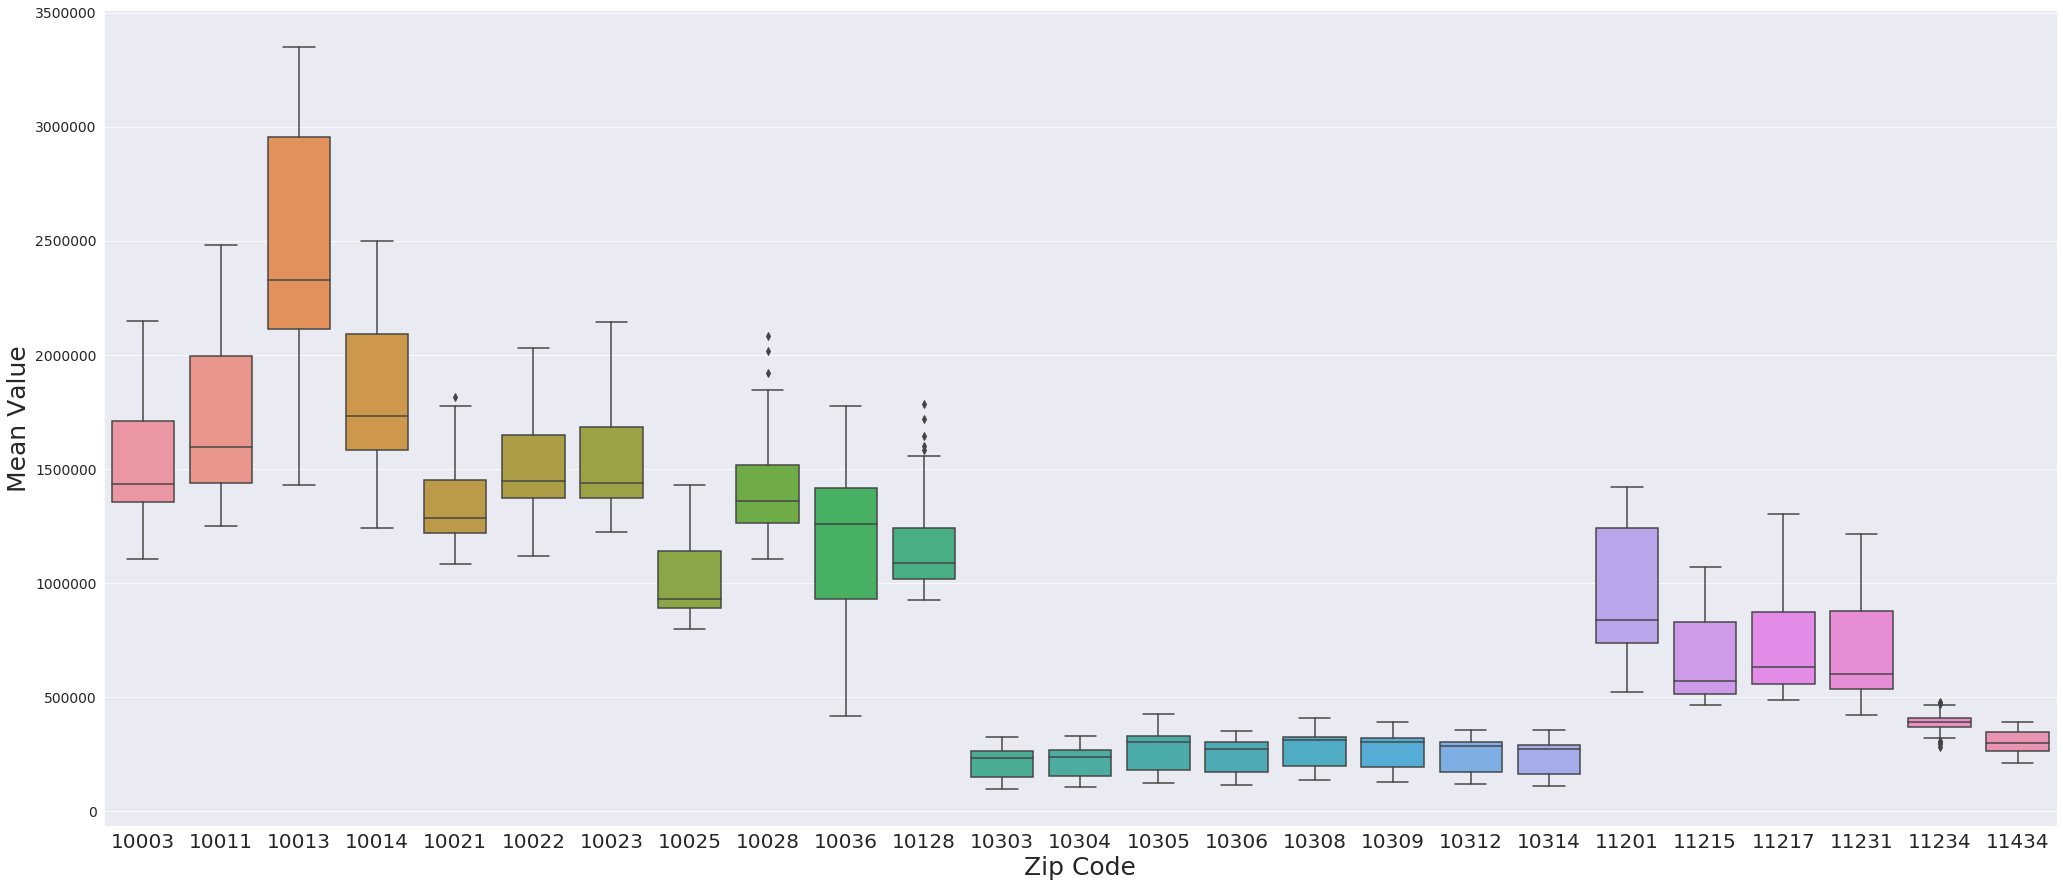

In [12]:
#Box and Whiskers Plot To Represent Mean Value of Properties In Zip Code
fig, ax = plt.subplots(figsize=(35,15))
sns.boxplot(x='RegionName', y='MeanValue', data=melted, ax=ax)
plt.xticks(fontsize=20)
plt.xlabel('Zip Code', fontsize=25)
plt.ylabel('Mean Value', fontsize=25)
plt.yticks(fontsize=14)

# Time Series

In [13]:
from ARIMA import df_ts

df_ts=df_ts(zipcodes,melted)
df_ts

[            RegionName  MeanValue
 Month                            
 2005-04-01       10025   798600.0
 2005-05-01       10025   798800.0
 2005-06-01       10025   801500.0
 2005-07-01       10025   804600.0
 2005-08-01       10025   814900.0
 ...                ...        ...
 2017-02-01       10025  1317300.0
 2017-03-01       10025  1333700.0
 2017-04-01       10025  1352100.0
 2017-05-01       10025  1390000.0
 2017-06-01       10025  1431000.0
 
 [147 rows x 2 columns],
             RegionName  MeanValue
 Month                            
 2004-09-01       10023  1526800.0
 2004-10-01       10023  1424500.0
 2004-11-01       10023  1346600.0
 2004-12-01       10023  1331300.0
 2005-01-01       10023  1322500.0
 ...                ...        ...
 2017-02-01       10023  1929800.0
 2017-03-01       10023  1955000.0
 2017-04-01       10023  2022400.0
 2017-05-01       10023  2095000.0
 2017-06-01       10023  2142300.0
 
 [154 rows x 2 columns],
             RegionName  MeanValue
 

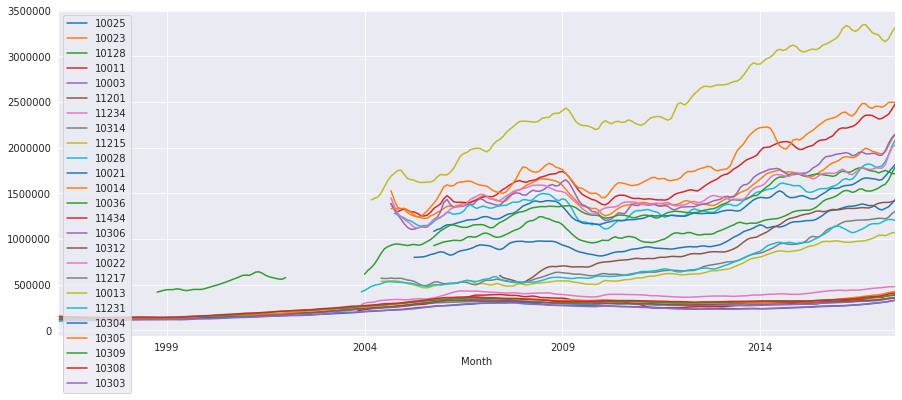

In [14]:
from ARIMA import timeseries
#Time Series Of Data For Each ZipCode
timeseries(df_ts)

/home/kasey/C1DC_Kasey_Suszko/ARIMA.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



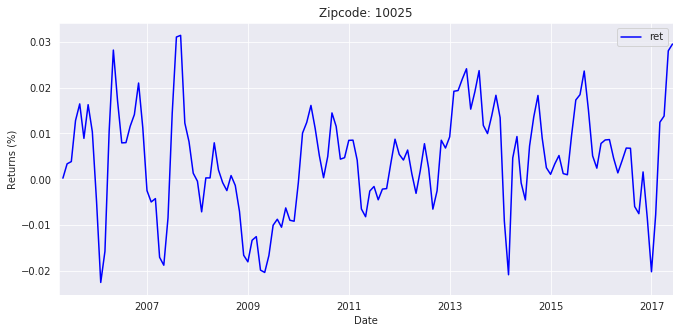

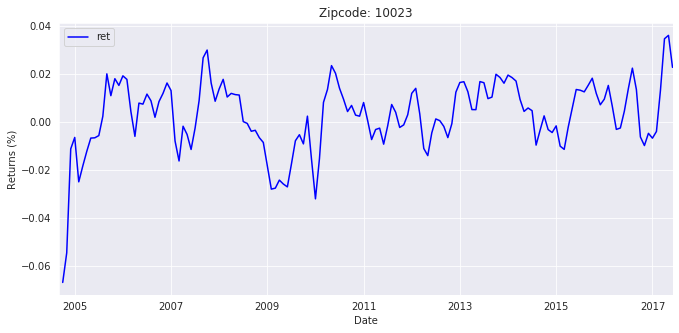

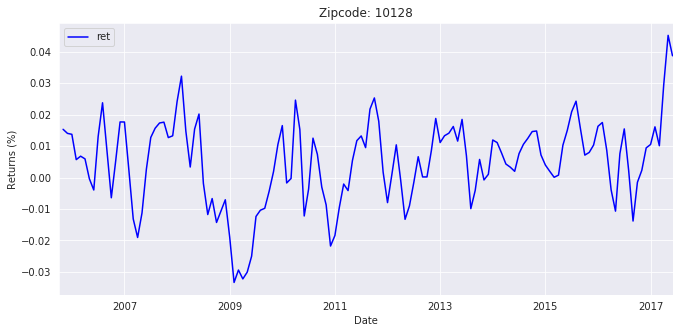

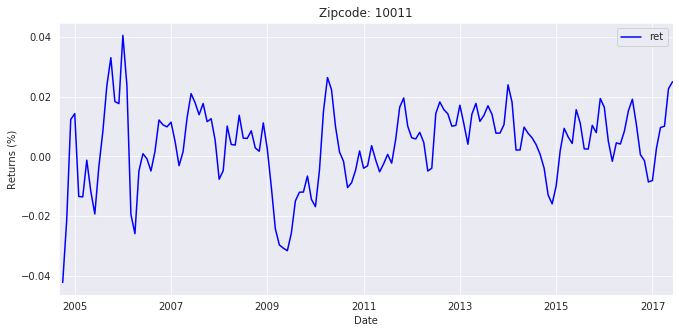

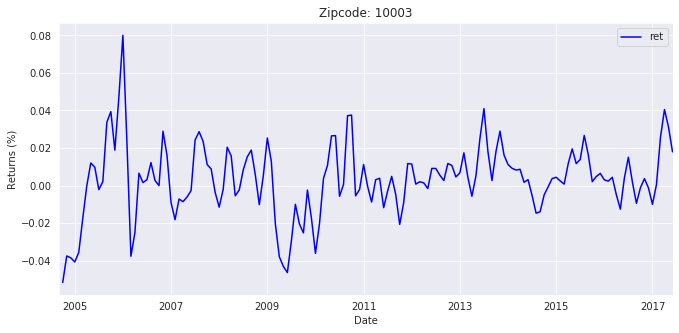

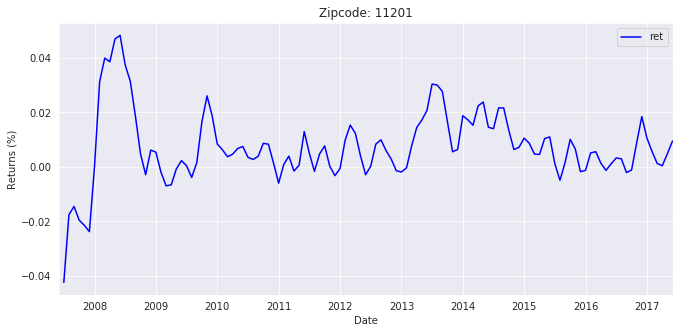

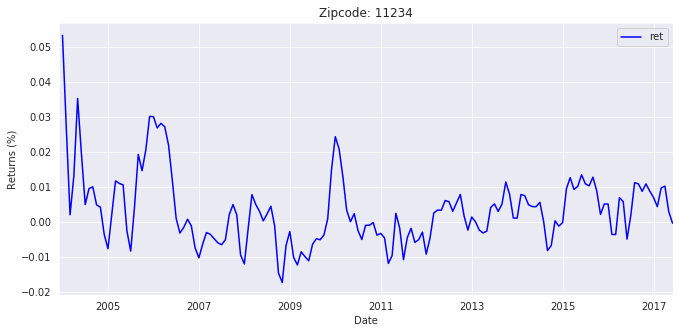

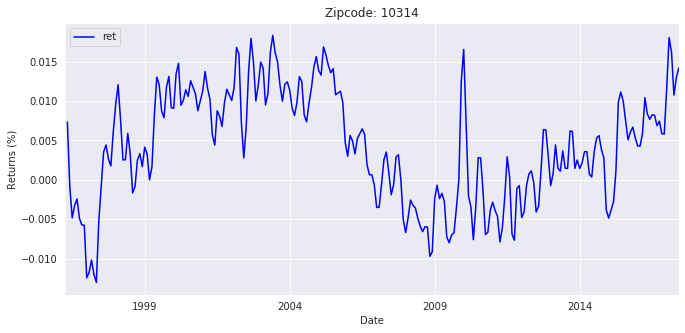

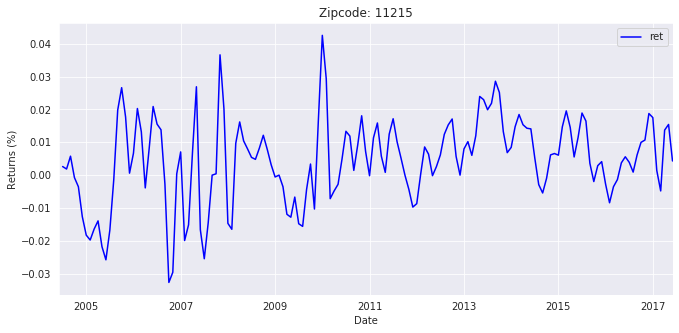

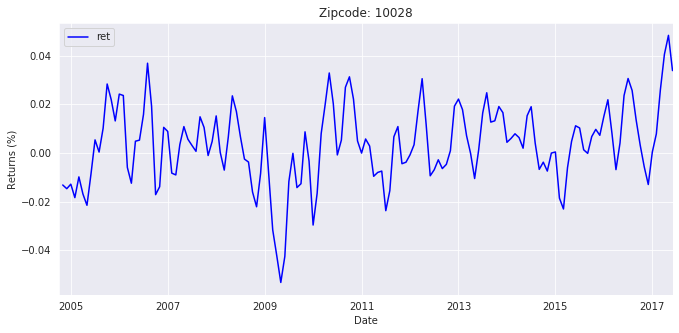

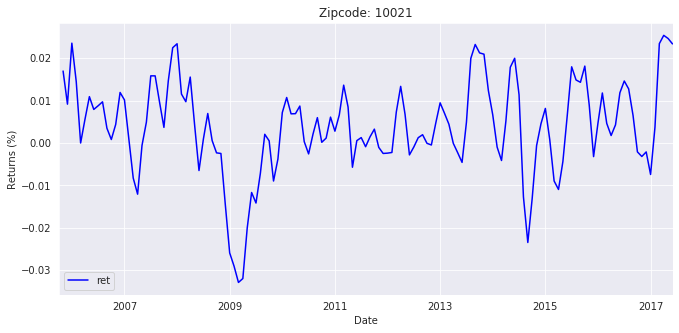

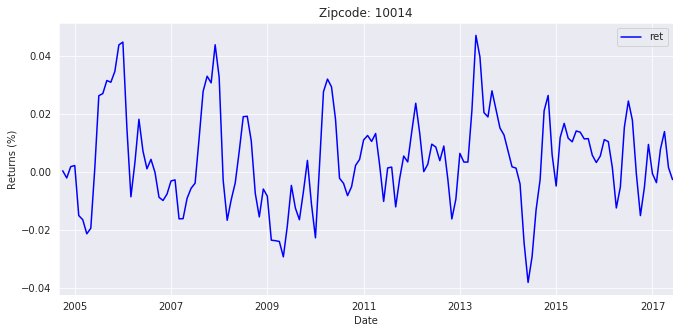

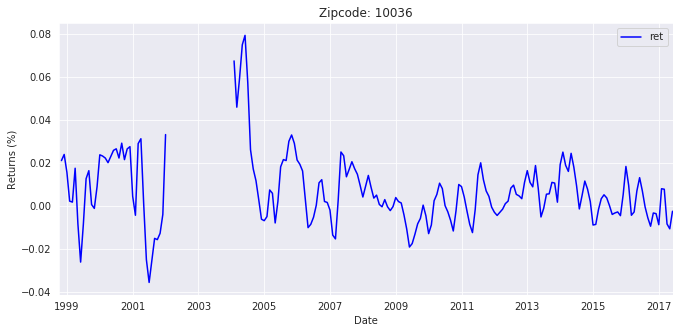

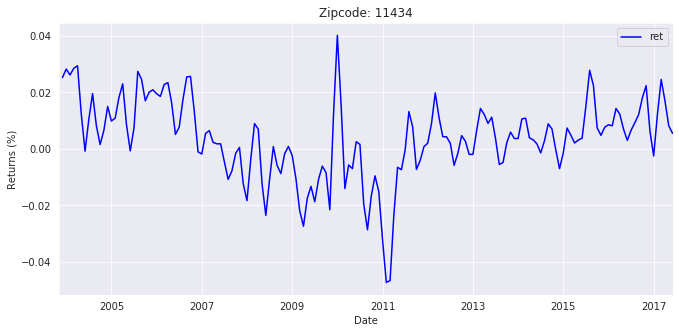

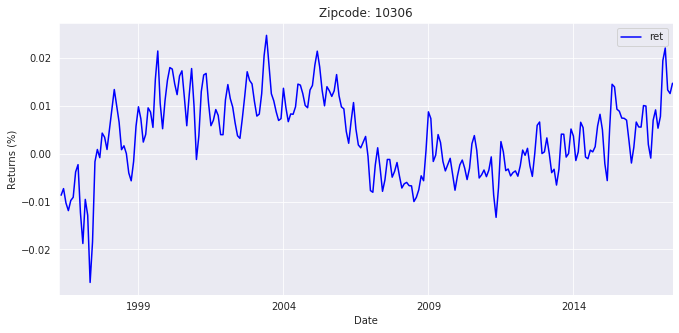

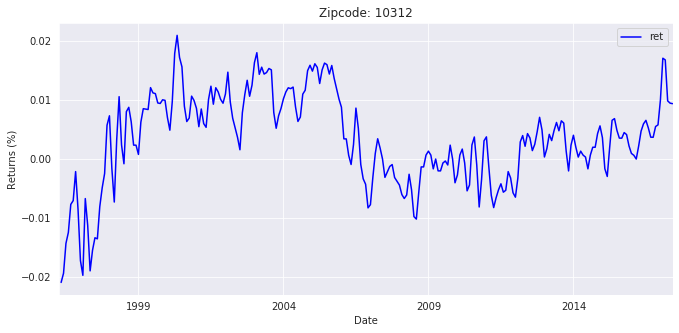

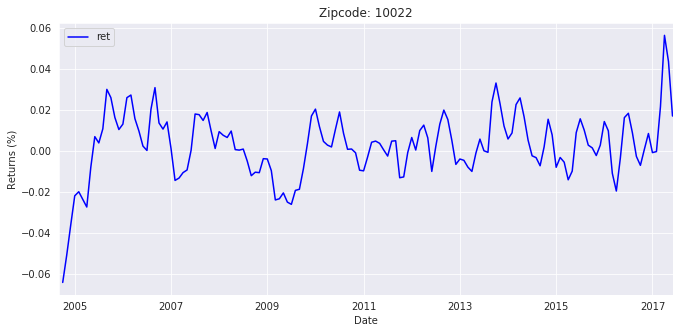

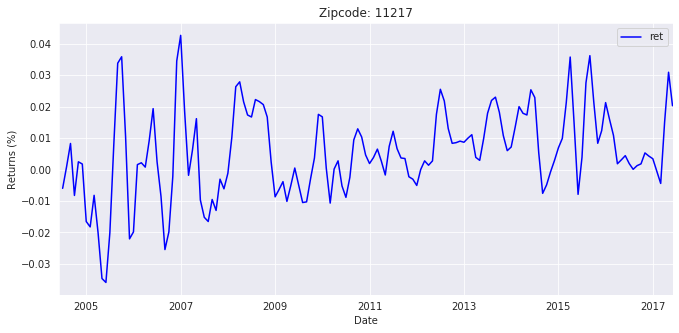

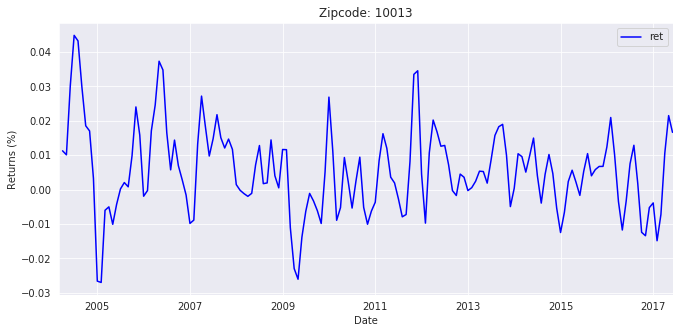

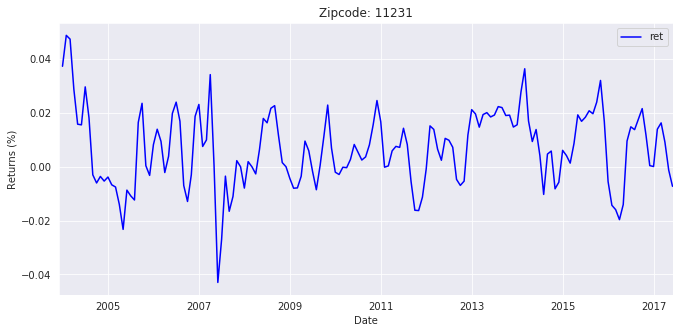

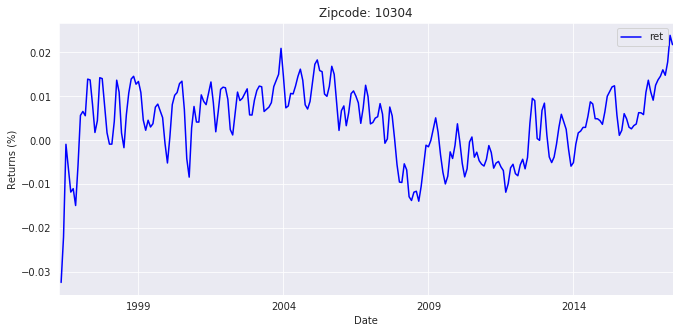

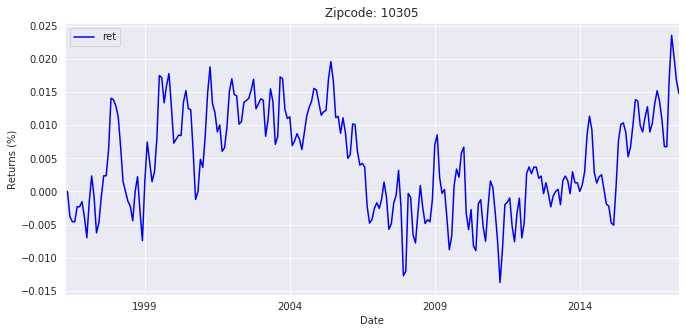

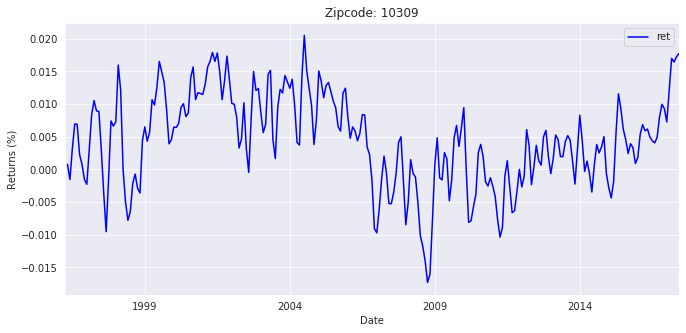

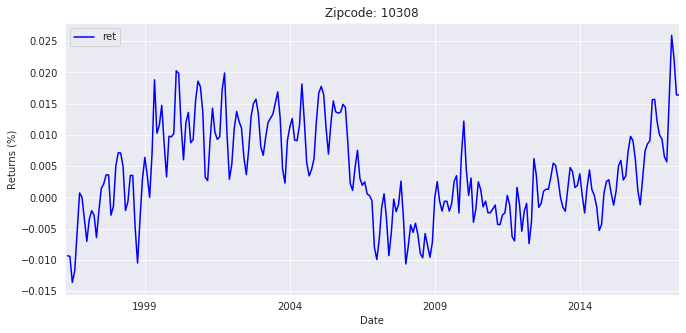

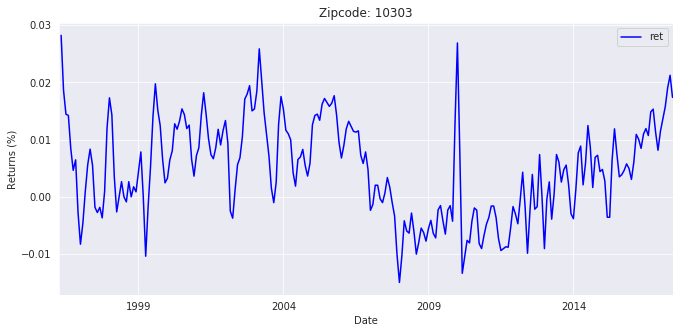

In [15]:
from ARIMA import monthly_return
monthly_return(df_ts)

In [16]:
#take the first difference for the data to be stationary
from ARIMA import adfuller_fisrt_diff
adfuller_fisrt_diff(df_ts)

ADFuller test p-value for zipcode: 10025
p-value: 0.0009837031705176636
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 10023
p-value: 0.000395363582298515
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 10128
p-value: 1.5945330370768046e-05
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 10011
p-value: 1.4604508455869118e-08
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 10003
p-value: 6.610457982633486e-09
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 11201
p-value: 3.0108712352763337e-06
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 11234
p-value: 3.252293023812224e-06
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 10314
p-value: 2.178881631433582e-06
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipc

The forecasted price today for 10025 is 1637396.2838243854
The last documented value for 10025 was 1431000.0
The forecasted price today for 10023 is 2333018.752917691
The last documented value for 10023 was 2142300.0
The forecasted price today for 10128 is 2123047.1601083833
The last documented value for 10128 was 1787100.0
The forecasted price today for 10011 is 2823250.1927188956
The last documented value for 10011 was 2480400.0
The forecasted price today for 10003 is 2384980.983804481
The last documented value for 10003 was 2147000.0
The forecasted price today for 11201 is 1700672.1383036852
The last documented value for 11201 was 1420700.0
The forecasted price today for 11234 is 521307.0361478735
The last documented value for 11234 was 476900.0
The forecasted price today for 10314 is 480142.0209411063
The last documented value for 10314 was 357300.0
The forecasted price today for 11215 is 1474954.2399369539
The last documented value for 11215 was 1070800.0
The forecasted price toda

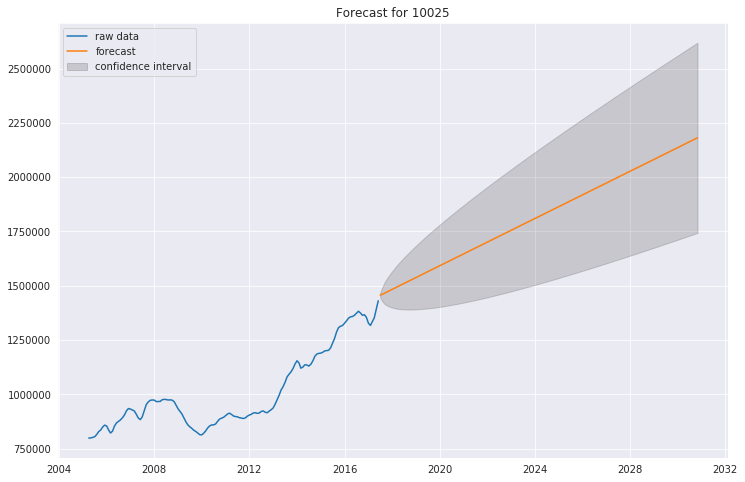

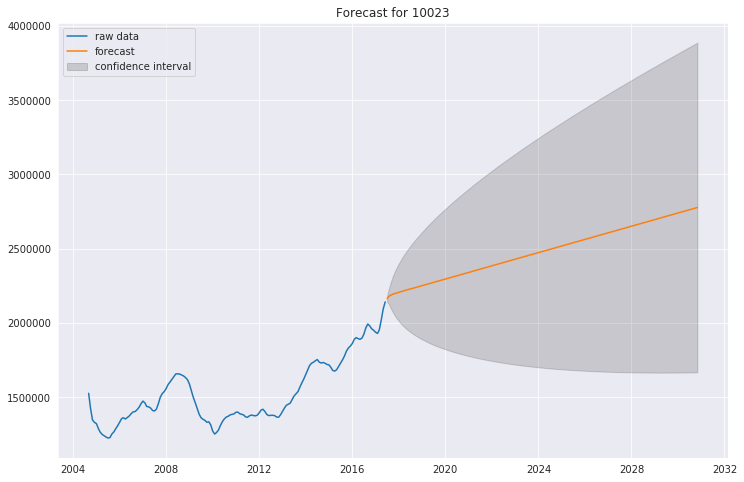

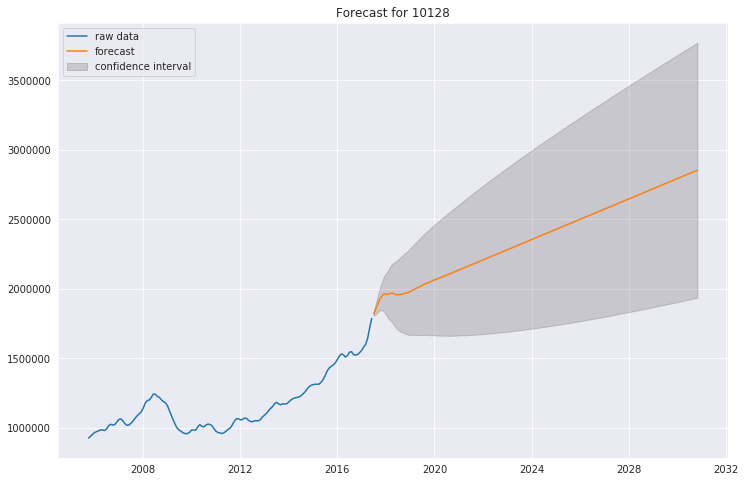

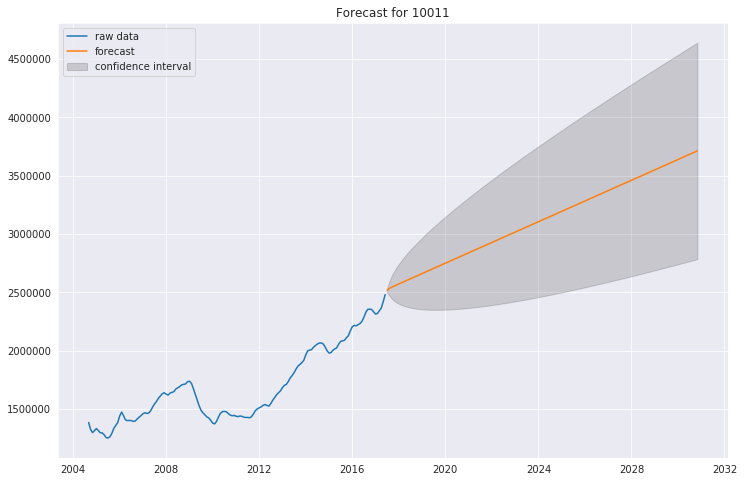

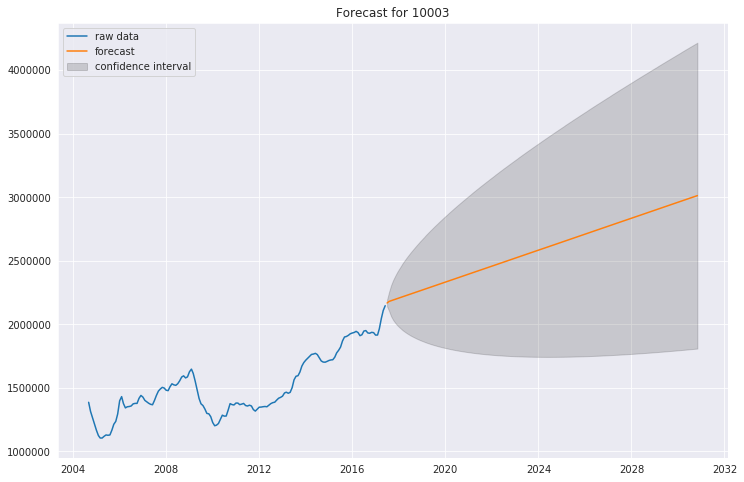

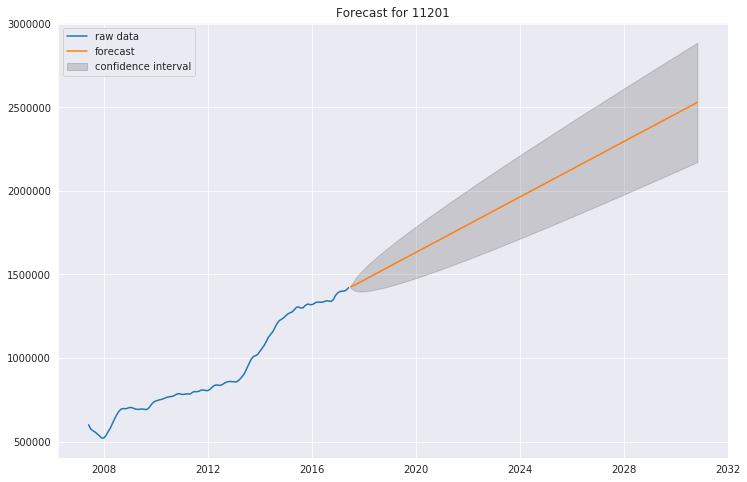

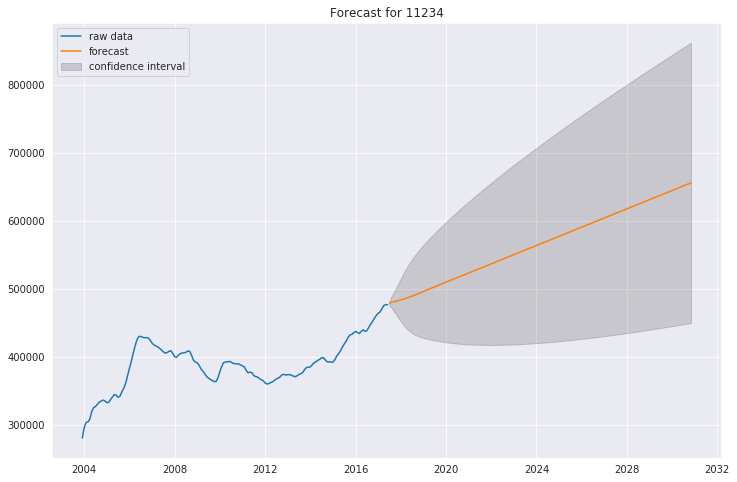

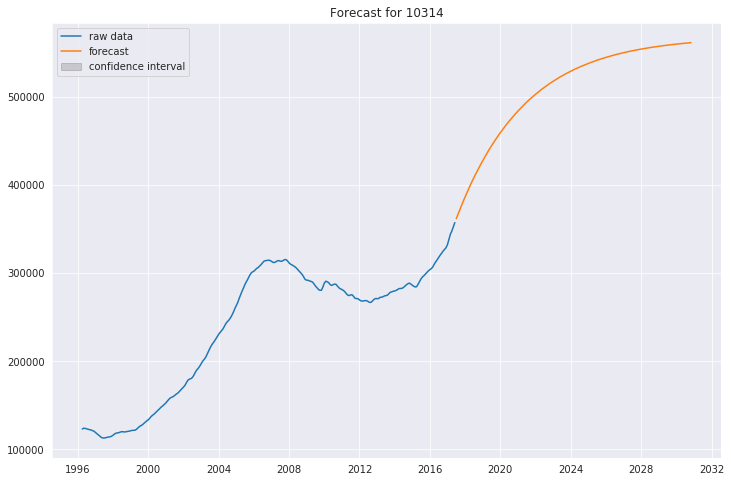

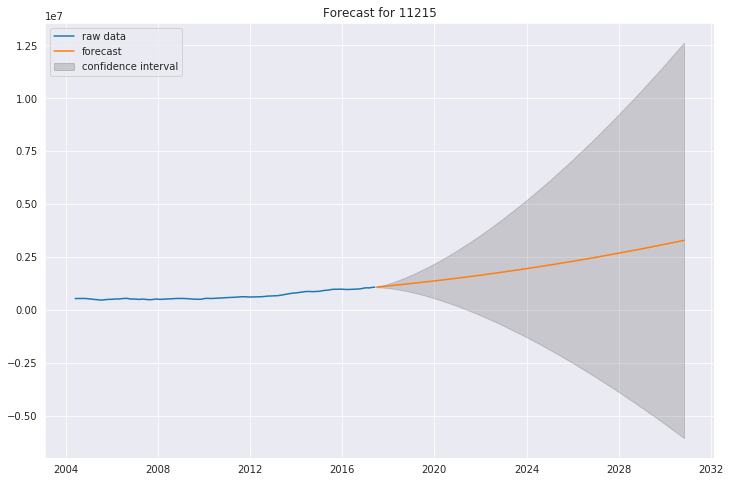

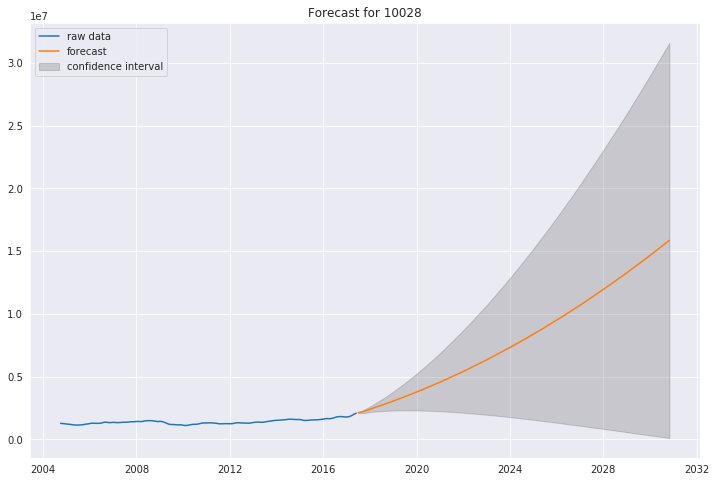

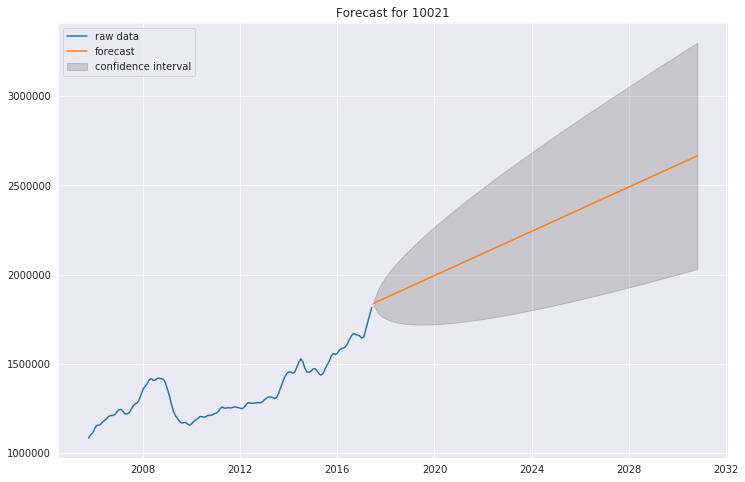

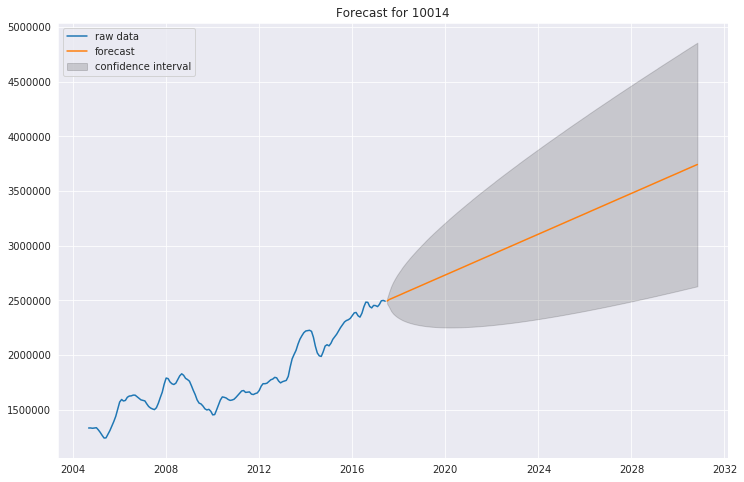

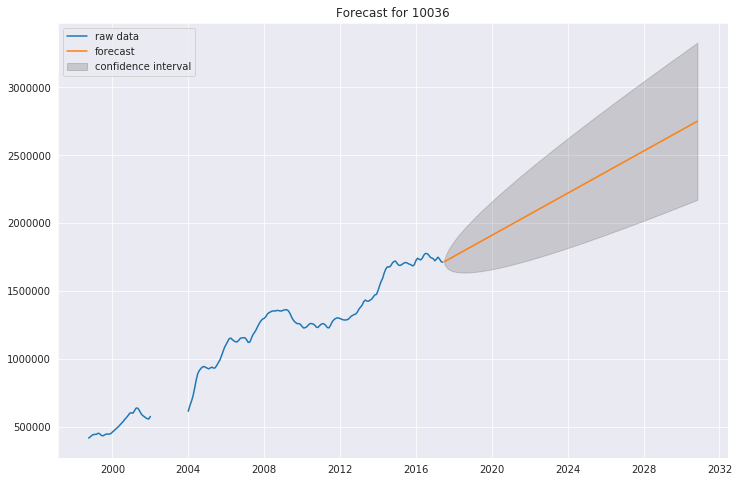

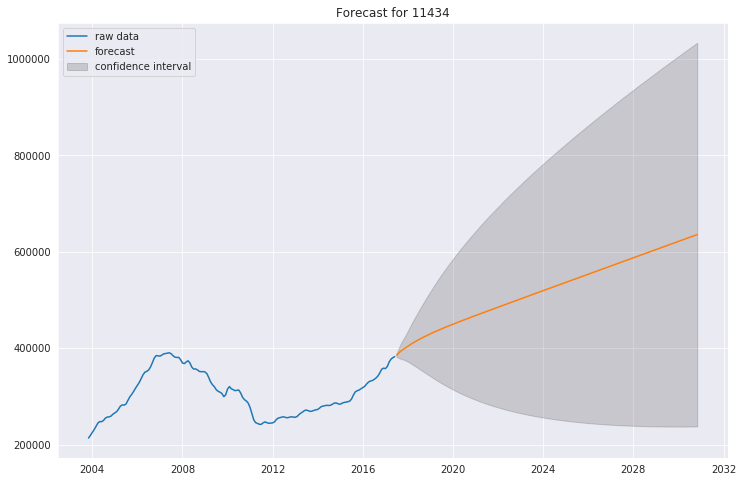

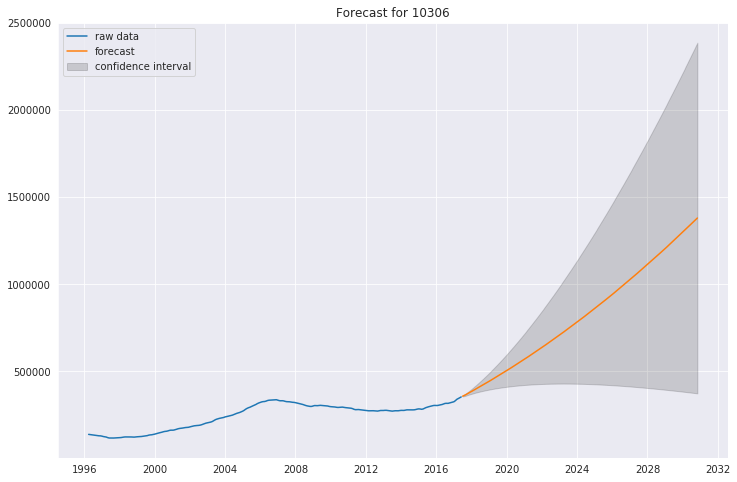

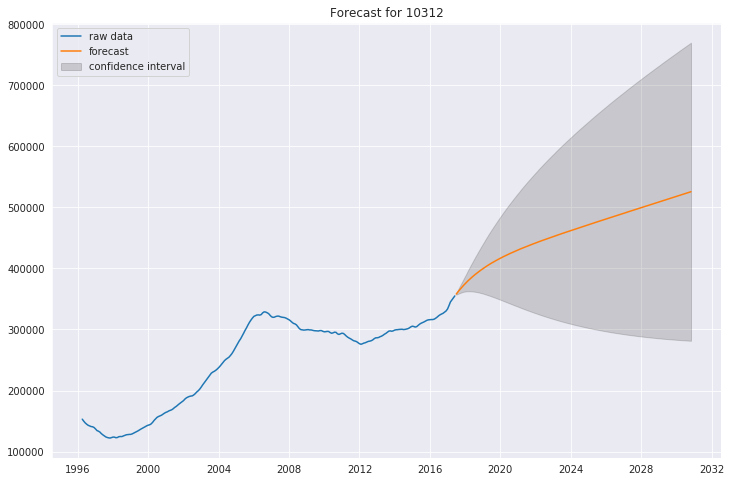

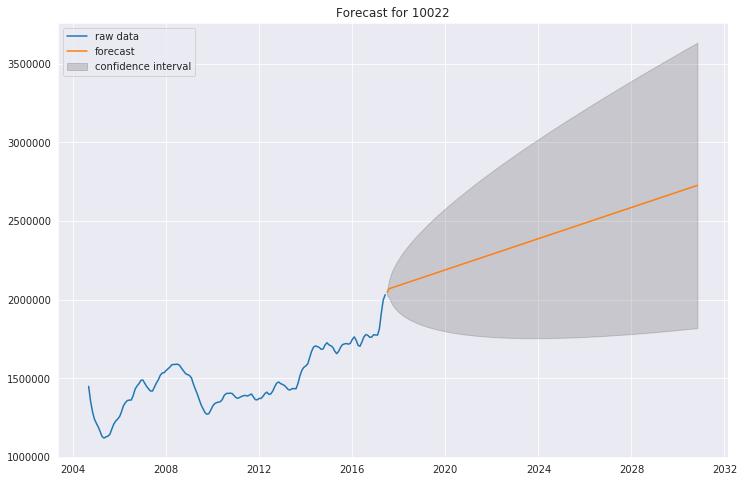

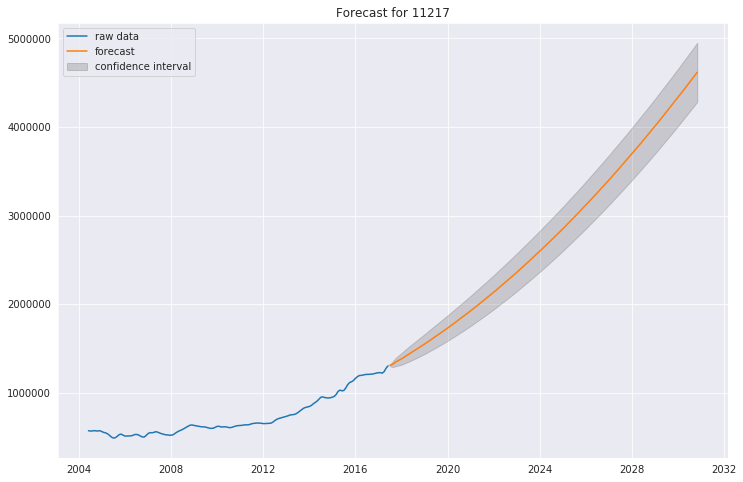

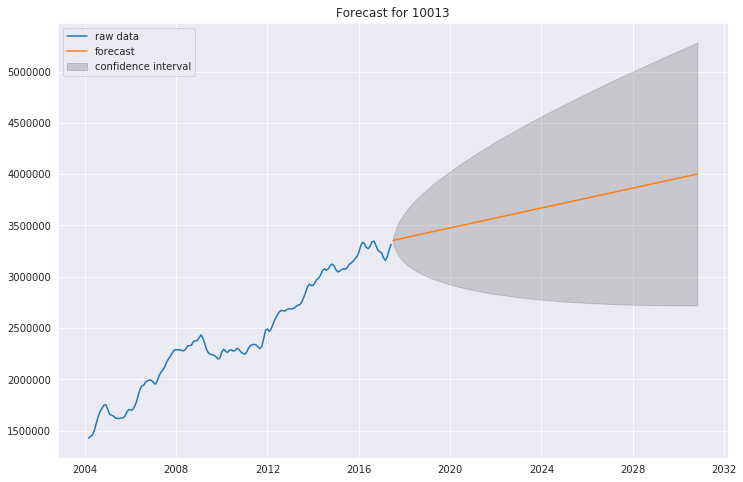

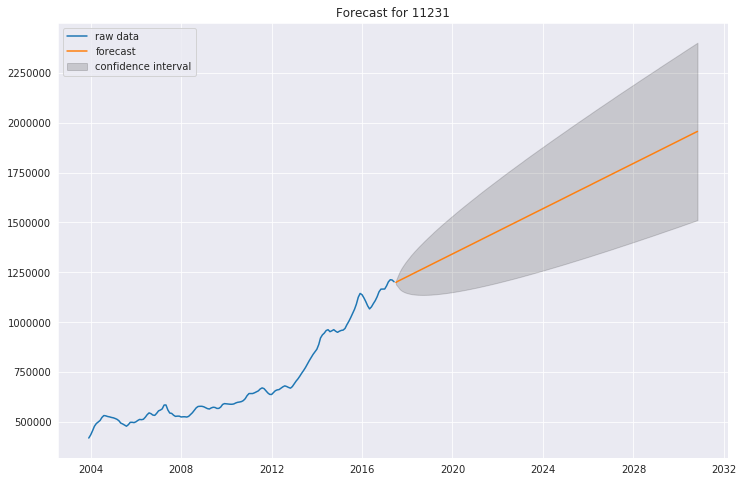

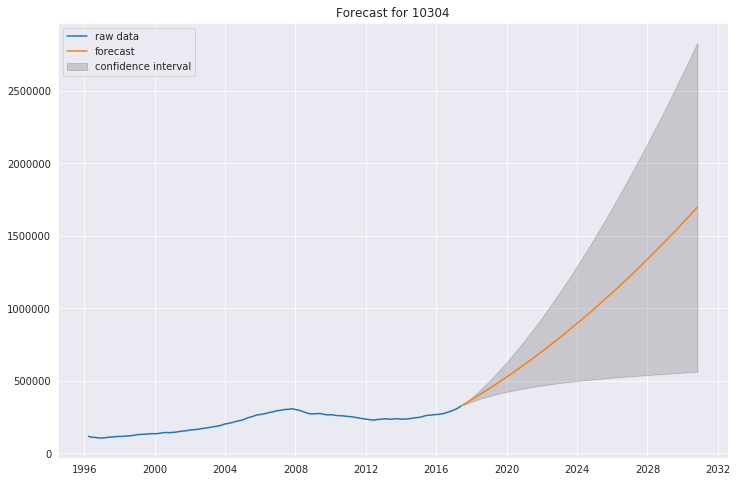

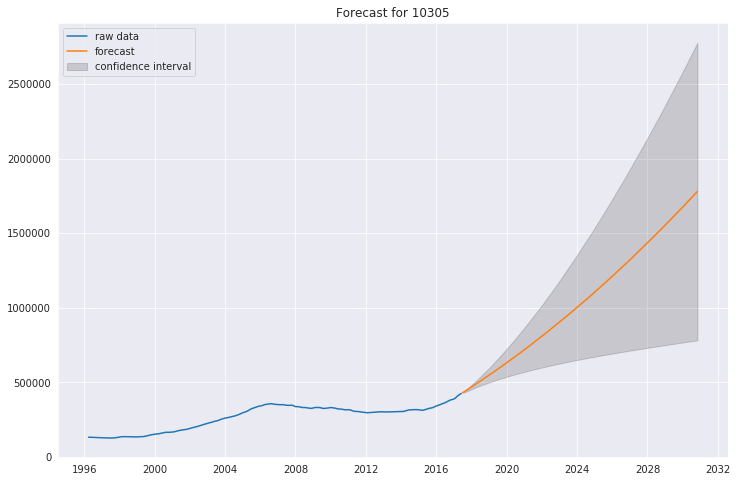

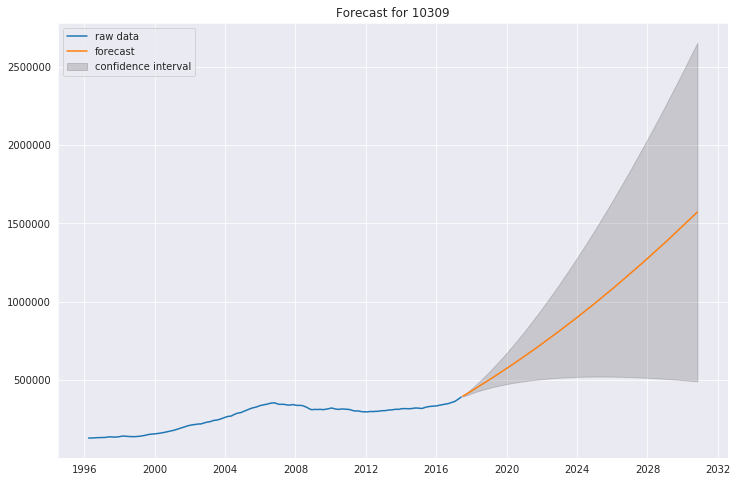

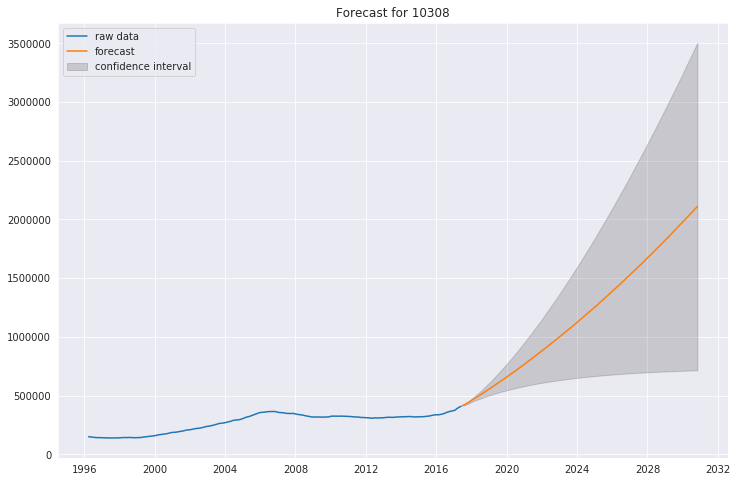

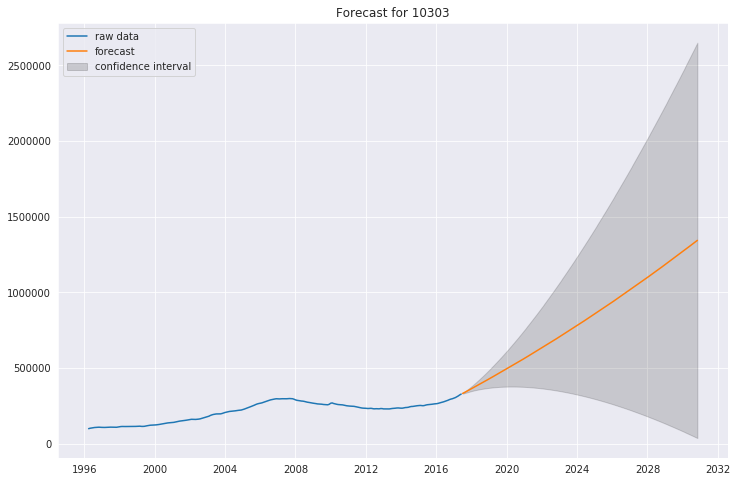

In [17]:
#orders were found using the "evaluate_models" function in ARIMA
#the function is not included in here because it takes hours to run
#normally I would not create a list manually, but due to time constraints I did
orders=[[1,1,2],[2,1,2],[8,1,0],[2,1,2],[0,1,2],[0,1,2],[8,1,2],[8,0,2],[4,2,2],[8,2,1],[0,1,2],[0,1,2],[0,1,2],[8,1,2],[4,2,1],[6,1,2],[0,1,2],[4,2,1],[0,1,2],[0,1,2],[2,2,2],[4,2,1],[8,2,0],[10,2,1],[4,2,0]]
#print(len(orders))
from ARIMA import ARIMA_model
ARIMA_model(df_ts, orders)

In [18]:
from ARIMA import ARIMA_forecasts
df_forecasts=ARIMA_forecasts(df_ts, orders)
print(df_forecasts)

[                   0      forecast   lower_bound   upper_bound
2005-04-01  798600.0           NaN           NaN           NaN
2005-05-01  798800.0           NaN           NaN           NaN
2005-06-01  801500.0           NaN           NaN           NaN
2005-07-01  804600.0           NaN           NaN           NaN
2005-08-01  814900.0           NaN           NaN           NaN
...              ...           ...           ...           ...
2030-07-01       NaN  2.163270e+06  1.730689e+06  2.595850e+06
2030-08-01       NaN  2.167803e+06  1.733837e+06  2.601769e+06
2030-09-01       NaN  2.172337e+06  1.736990e+06  2.607683e+06
2030-10-01       NaN  2.176870e+06  1.740147e+06  2.613593e+06
2030-11-01       NaN  2.181403e+06  1.743308e+06  2.619499e+06

[308 rows x 4 columns],                     0      forecast   lower_bound   upper_bound
2004-09-01  1526800.0           NaN           NaN           NaN
2004-10-01  1424500.0           NaN           NaN           NaN
2004-11-01  1346600.0     

In [19]:
from ARIMA import forecasts_cleaned 

df_forecasts_cleaned=forecasts_cleaned(df_forecasts)

In [20]:
print(df_forecasts_cleaned.head())

        2017-07       2017-08       2017-09       2017-10       2017-11  \
0  1.456664e+06  1.460430e+06  1.465172e+06  1.469649e+06  1.474197e+06   
0  2.164207e+06  2.180864e+06  2.187824e+06  2.194446e+06  2.198673e+06   
0  1.820604e+06  1.856222e+06  1.893635e+06  1.926775e+06  1.948545e+06   
0  2.517422e+06  2.530818e+06  2.541161e+06  2.548938e+06  2.556662e+06   
0  2.168542e+06  2.180804e+06  2.186039e+06  2.191274e+06  2.196510e+06   

        2017-12       2018-01       2018-02       2018-03       2018-04  ...  \
0  1.478727e+06  1.483261e+06  1.487794e+06  1.492328e+06  1.496861e+06  ...   
0  2.203056e+06  2.206824e+06  2.210693e+06  2.214397e+06  2.218144e+06  ...   
0  1.963665e+06  1.961856e+06  1.960722e+06  1.965996e+06  1.970821e+06  ...   
0  2.564071e+06  2.571515e+06  2.578914e+06  2.586324e+06  2.593726e+06  ...   
0  2.201745e+06  2.206980e+06  2.212216e+06  2.217451e+06  2.222686e+06  ...   

        AR_2021       AR_2022       AR_2023       AR_2024       AR_2

In [21]:
#upon observation, ARIMA is not the best forecast method for some zips
#Data which was initially stationary may have been incorrectly forecasted
#will use CAGR to calculate values for ARIMAs with poor fit

# CAGR Calculations

CAGR=((med2/med1)n−1)∗100

med1: Medp for year t

med2: Medp for year t+x

n (number of years): t + x - t = x


### Calculating 2020 median property values
Assumptions:

CAGR would be a decent indicator to forecast property and rent prices

2020 median property costs would be better reflected by using cagr 3 year growth rate and forecasting the present property costs using 2017 median property costs

2020MedianPropertyCost=(2017MedianPropertyCost)∗(1+(CAGR/100))^3

In [22]:
from ARIMA import CAGR

df_CAGR=CAGR(df_monthly)

print(df_CAGR.head())

   RegionName  1996-04  1996-05  1996-06  1996-07  1996-08  1996-09  1996-10  \
0       10025      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2       10023      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
13      10128      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14      10011      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
20      10003      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

    1996-11  1996-12  ...  2017-03  2017-04  2017-05  2017-06  2017_Median  \
0       NaN      NaN  ...  1333700  1352100  1390000  1431000    1333700.0   
2       NaN      NaN  ...  1955000  2022400  2095000  2142300    1955000.0   
13      NaN      NaN  ...  1598900  1646100  1720500  1787100    1598900.0   
14      NaN      NaN  ...  2342100  2365900  2419700  2480400    2342100.0   
20      NaN      NaN  ...  1965700  2045300  2109100  2147000    1965700.0   

    2014_Median    CAGR_3    2020_CAGR3    2025_CA

# Combining ARIMA and CAGR
For models which ARIMA did not seem a good fit, I used the CAGR for the best value for 2020

In [23]:
df_combined = pd.concat([df_CAGR.reset_index(drop=True),df_forecasts_cleaned.reset_index(drop=True)], axis=1)
df_combined= df_combined.rename(columns={'RegionName':'zipcode'})

print(df_combined)


   zipcode   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
0    10025       NaN       NaN       NaN       NaN       NaN       NaN   
1    10023       NaN       NaN       NaN       NaN       NaN       NaN   
2    10128       NaN       NaN       NaN       NaN       NaN       NaN   
3    10011       NaN       NaN       NaN       NaN       NaN       NaN   
4    10003       NaN       NaN       NaN       NaN       NaN       NaN   
5    11201       NaN       NaN       NaN       NaN       NaN       NaN   
6    11234       NaN       NaN       NaN       NaN       NaN       NaN   
7    10314  123100.0  124000.0  123900.0  123300.0  122900.0  122600.0   
8    11215       NaN       NaN       NaN       NaN       NaN       NaN   
9    10028       NaN       NaN       NaN       NaN       NaN       NaN   
10   10021       NaN       NaN       NaN       NaN       NaN       NaN   
11   10014       NaN       NaN       NaN       NaN       NaN       NaN   
12   10036       NaN       NaN       N

In [24]:
#Combine best values from ARIMA and CAGR for the optimal 2020 forecast
from ARIMA import clean_combined

df_cc=clean_combined(df_combined)

print(df_cc)
#df_cc.to_csv('zillow_cleaned')

   zipcode   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
0    10025       NaN       NaN       NaN       NaN       NaN       NaN   
1    10023       NaN       NaN       NaN       NaN       NaN       NaN   
2    10128       NaN       NaN       NaN       NaN       NaN       NaN   
3    10011       NaN       NaN       NaN       NaN       NaN       NaN   
4    10003       NaN       NaN       NaN       NaN       NaN       NaN   
5    11201       NaN       NaN       NaN       NaN       NaN       NaN   
6    11234       NaN       NaN       NaN       NaN       NaN       NaN   
7    10314  123100.0  124000.0  123900.0  123300.0  122900.0  122600.0   
8    11215       NaN       NaN       NaN       NaN       NaN       NaN   
9    10028       NaN       NaN       NaN       NaN       NaN       NaN   
10   10021       NaN       NaN       NaN       NaN       NaN       NaN   
11   10014       NaN       NaN       NaN       NaN       NaN       NaN   
12   10036       NaN       NaN       N